<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 4:
###
---

## 4. Modeling

### 4.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import time # we'll use this to see how long the models run

# For graphs and visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Essential library imports for Modeling Pre-Processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Library to load the Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For Modeling Pipeline & Hyperparameter Tuning (GridSearchCV)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# For Modeling Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, f1_score, RocCurveDisplay

# For Deep Learning Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-04-11 16:11:55.034431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 4.2 Import cleaned dataset

In [2]:
df = pd.read_csv('../data/final_dataset.csv')
df.head()

,height,weight,bmi,yrssmok,packday,sleep_hours,age,health_status,phys_health_not_good,mental_health_not_good,...,asthma_status,race_ethnicity,sex,education,income,smoker_status,e_cig_smoker,binge_drinker,heavy_drinker,chd_mi
0,1.744,81.376,28.054,0.0,0.0,8.0,80.0,2.0,1.0,1.0,...,3.0,1.0,2.0,4.0,7.0,4.0,1.0,1.0,1.0,2.0
1,1.600,68.040,26.580,0.0,0.0,6.0,80.0,1.0,1.0,1.0,...,3.0,1.0,2.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0
2,1.570,63.500,25.760,0.0,0.0,5.0,56.0,2.0,2.0,2.0,...,3.0,1.0,2.0,4.0,10.0,4.0,1.0,1.0,1.0,2.0
3,1.650,63.500,23.320,56.0,0.1,7.0,73.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,7.0,2.0,1.0,1.0,1.0,2.0
4,1.570,53.980,21.900,0.0,0.0,9.0,43.0,4.0,2.0,1.0,...,3.0,1.0,2.0,3.0,5.0,4.0,1.0,1.0,1.0,2.0


### 4.3 Checking the dataset

#### 4.3.1 Checking columns and datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440111 entries, 0 to 440110
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   height                     440111 non-null  float64
 1   weight                     440111 non-null  float64
 2   bmi                        440111 non-null  float64
 3   yrssmok                    440111 non-null  float64
 4   packday                    440111 non-null  float64
 5   sleep_hours                440111 non-null  float64
 6   age                        440111 non-null  float64
 7   health_status              440111 non-null  float64
 8   phys_health_not_good       440111 non-null  float64
 9   mental_health_not_good     440111 non-null  float64
 10  last_routine_checkup       440111 non-null  float64
 11  visit_dentist_past_year    440111 non-null  float64
 12  health_insurance           440111 non-null  float64
 13  phy_exercise_past_30_days  44

#### 4.3.2 Check for imbalanced dataset (using target variable - `chd_mi`)

In [4]:
percentage_responses = df['chd_mi'].value_counts(normalize=True)*100

print(percentage_responses)

chd_mi
2.0    90.96796
1.0     9.03204
Name: proportion, dtype: float64


**Analysis:**

* We checked that there are no null values - all null values have been rectified at the data cleaning stage.
* There is a imbalance in the dataset - with 90.96% of respondents did not report having any heart disease or myocardial infarctions, while the remaining 9.03% reported having heart disease or myocardial infarctions. We will rectify the imbalance during the when fitting the model into the pipeline through parameter tuning and pipeline measures.

### 4.4 Modeling

#### 4.4.1 Baseline Models

Prior to modeling, the null values have been rectified in the Data Cleaning stage. For the purpose of this project, we will run look into 4 Classifier-type models as a baseline.

- **Logistic Regression**
  - Simplicity and Interpretability: As a straightforward algorithm, it serves as a good starting point for binary classification tasks. It provides a probabilistic framework which means that besides making predictions, it can also quantify the uncertainty of its predictions, which is useful for understanding the impact of each feature on the prediction.
  - Performance: Despite its simplicity, Logistic Regression can perform quite well on linearly separable data.
  - Speed: It's computationally inexpensive, making it fast for both training and prediction, which is beneficial when working with very large datasets.
  - Baseline Comparison: Commonly used as a benchmark because of the ease to implement and interpret.

- **XGBoost**
  - Accuracy: XGBoost is known for its high performance and speed in classification problems, using a gradient boosting framework.
  - Flexibility: XGBoost allows users to define custom optimization objectives and evaluation criteria, adding a layer of sophistication to the modeling.

- **Random Forest**
  - Versatility: Random Forest performs well on a wide range of data types without the need for extensive data preprocessing like scaling and normalization.
  - Robustness: As an ensemble method, it is less prone to overfitting than a single decision tree and often has a very good performance right out of the box.
  - Feature Importance: It provides a straightforward indication of feature importance based on how much they contribute to reducing variance, which is helpful for feature selection.

- **Decision Trees**
  
  - Non-Parametric: As a non-parametric method, it makes no assumptions about the underlying distributions of the data, which is useful for practical applications.
  - Handling Non-Linear Relationships: It can capture non-linear relationships between features and the target variable.



##### 4.4.1.1 Logistic Regression

In [5]:
# Separate features and target from the cleaned dataframe
log_X = df.drop('chd_mi', axis=1)
log_y = df['chd_mi'].astype(int).map({1: 0, 2: 1})  # Map values and ensure int type

# Encoding categorical variables
log_X_encoded = pd.get_dummies(log_X)

# Ensuring log_X and log_y have consistent lengths
assert len(log_X_encoded) == len(log_y), "log_X and log_y have inconsistent number of samples."

# Perform the train-test split
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(log_X_encoded, log_y, test_size=0.2, stratify=log_y, random_state=42)

In [6]:
# Feature scaling
scaler = StandardScaler()
log_X_train_scaled = scaler.fit_transform(log_X_train)
log_X_test_scaled = scaler.transform(log_X_test)

In [7]:
%%time
# Initialize the Logistic Regression model with a higher max_iter
model = LogisticRegression(max_iter=5000, random_state=42)

# Train the model on the scaled data
model.fit(log_X_train_scaled, log_y_train)

# Make predictions using the correctly scaled data
log_train_pred = model.predict(log_X_train_scaled)
log_test_pred = model.predict(log_X_test_scaled)

# Calculate and print training and test accuracies
log_train_accuracy = accuracy_score(log_y_train, log_train_pred)
log_test_accuracy = accuracy_score(log_y_test, log_test_pred)
print(f"LogReg Train Accuracy: {log_train_accuracy * 100:.2f}%")
print(f"LogReg Test Accuracy: {log_test_accuracy * 100:.2f}%")

# For cross-validation, ensure data is scaled before the process
log_cv_scores = cross_val_score(model, scaler.fit_transform(log_X_encoded), log_y, cv=5, scoring='accuracy')

# Print the average of the cross-validation scores and scores for each fold
print(f"LogReg Cross-Validation: {log_cv_scores.mean() * 100:.2f}%")
print(f"LogReg Cross-Validation (per Fold): {[f'{score * 100:.2f}%' for score in log_cv_scores]}")

LogReg Train Accuracy: 91.09%
LogReg Test Accuracy: 91.12%
LogReg Cross-Validation: 91.09%
LogReg Cross-Validation (per Fold): ['91.05%', '91.08%', '91.10%', '91.10%', '91.13%']
CPU times: user 12.5 s, sys: 1.77 s, total: 14.3 s
Wall time: 4.9 s


##### 4.4.1.2 XGBoost

In [9]:
# Separate features and target
xg_X = df.drop('chd_mi', axis=1)
xg_y = df['chd_mi'].astype(int)

# Map the values of xg_y from [1, 2] to [0, 1]
xg_y_mapped = xg_y.map({1: 0, 2: 1})

# Verify the consistency in the number of samples between xg_X and y_mapped
assert len(xg_X) == len(xg_y_mapped), "The feature set xg_X and target variable y_mapped have inconsistent lengths."

# Now, you can safely perform the train-test split
xg_X_train, xg_X_test, xg_y_train, xg_y_test = train_test_split(xg_X, xg_y_mapped, test_size=0.2, stratify=xg_y_mapped, random_state=42)

In [10]:
%%time
# Initialize the XGBoost classifier with enable_categorical=True
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Train the model using the correct xg_y_train variable
model.fit(xg_X_train, xg_y_train)  # Use xg_y_train directly after ensuring it's correctly mapped and split

# Make predictions on training and test sets
xg_train_pred = model.predict(xg_X_train)
xg_test_pred = model.predict(xg_X_test)

# Calculate and print training and test accuracies
# Here, make sure to use 'xg_y_train' and 'xg_y_test' which are the variables you should have defined after the train-test split and mapping
xg_train_accuracy = accuracy_score(xg_y_train, xg_train_pred)
xg_test_accuracy = accuracy_score(xg_y_test, xg_test_pred)
print(f"XGBoost Train Accuracy: {xg_train_accuracy * 100:.2f}%")
print(f"XGBoost Test Accuracy: {xg_test_accuracy * 100:.2f}%")

# Ensure X is suitable for cross-validation by converting object types to 'category' if needed
# This step might not be necessary for models like XGBoost when using enable_categorical=True
# but is kept for demonstration or if you plan to use models that do not natively support categorical features
xg_X_for_cv = xg_X.copy()
for col in xg_X_for_cv.columns:
    if xg_X_for_cv[col].dtype == 'object':
        xg_X_for_cv[col] = xg_X_for_cv[col].astype('category')

# Perform 5-fold cross-validation using the mapped y
xg_cv_scores = cross_val_score(model, xg_X_for_cv, xg_y_mapped, cv=5, scoring='accuracy')

# Print the average of the cross-validation scores and the scores for each fold
print(f"XGBoost Cross-Validation: {xg_cv_scores.mean() * 100:.2f}%")
print(f"XGBoost Cross-Validation (per Fold): {[f'{score * 100:.2f}%' for score in xg_cv_scores]}")

XGBoost Train Accuracy: 91.65%
XGBoost Test Accuracy: 91.10%
XGBoost Cross-Validation: 91.06%
XGBoost Cross-Validation (per Fold): ['91.04%', '91.07%', '91.04%', '91.02%', '91.10%']
CPU times: user 1min 20s, sys: 9.54 s, total: 1min 29s
Wall time: 12.4 s


##### 4.4.1.3 Random Forest

In [11]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Separate features and target
rf_X = df.drop('chd_mi', axis=1)
rf_y = df['chd_mi']

# Encoding categorical variables
rf_X_encoded = pd.get_dummies(rf_X)

# Splitting dataset into training and testing sets
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X_encoded, rf_y, test_size=0.2, stratify=rf_y, random_state=42)

In [13]:
%%time
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)

# Training the model
model.fit(rf_X_train, rf_y_train)

# Making predictions for evaluation
rf_y_train_pred = model.predict(rf_X_train)
rf_y_test_pred = model.predict(rf_X_test)

# Calculating Train and Test accuracy scores
rf_train_accuracy = accuracy_score(rf_y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(rf_y_test, rf_y_test_pred)
print(f"Random Forest Train Accuracy: {rf_train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy: {rf_test_accuracy * 100:.2f}%")

# Perform 5-fold cross-validation to evaluate the model
rf_cv_scores = cross_val_score(model, rf_X_encoded, rf_y, cv=5)

# Calculate and print the average of the cross-validation scores
cv_mean = rf_cv_scores.mean()
cv_std = rf_cv_scores.std()
print(f"Random Forest Cross-Validation: {rf_cv_scores.mean() * 100:.2f}%")
print(f"Random Forest Cross-Validation (per Fold): {[f'{score * 100:.2f}%' for score in rf_cv_scores]}")

Random Forest Train Accuracy: 99.97%
Random Forest Test Accuracy: 91.04%
Random Forest Cross-Validation: 90.99%
Random Forest Cross-Validation (per Fold): ['90.97%', '90.99%', '91.00%', '91.00%', '91.02%']
CPU times: user 7min 9s, sys: 9.28 s, total: 7min 19s
Wall time: 7min 31s


##### 4.4.1.4 Decision Tree

In [14]:
# Separate features and target
dt_X = df.drop('chd_mi', axis=1)
dt_y = df['chd_mi']

# Separate numerical and categorical columns
numeric_features = dt_X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = dt_X.select_dtypes(include=['object', 'category']).columns

# Scale the numerical features
scaler = StandardScaler()
dt_X_numeric_scaled = scaler.fit_transform(dt_X[numeric_features])

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
dt_X_categorical_encoded = encoder.fit_transform(dt_X[categorical_features])

# Combine the processed numerical and categorical features back into a single dataset
dt_X_processed = np.concatenate([dt_X_numeric_scaled, dt_X_categorical_encoded], axis=1)

# Now you have a fully processed dataset, you can split it into training and testing sets
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X_processed, dt_y, test_size=0.2, stratify=dt_y, random_state=42)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
%%time
# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(dt_X_train, dt_y_train)

# Make predictions
dt_y_train_pred = model.predict(dt_X_train)
dt_y_test_pred = model.predict(dt_X_test)

# Evaluate the model
dt_train_accuracy = accuracy_score(dt_y_train, dt_y_train_pred)
dt_test_accuracy = accuracy_score(dt_y_test, dt_y_test_pred)
print(f"Decision Trees Train Accuracy: {dt_train_accuracy * 100:.2f}%")
print(f"Decision Trees Test Accuracy: {dt_test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in dt_X.columns:
    if dt_X[col].dtype == 'object':
        dt_X[col] = dt_X[col].astype('category')

dt_cv_scores = cross_val_score(model, dt_X_processed, dt_y, cv=5)
cv_mean = dt_cv_scores.mean()
cv_std = dt_cv_scores.std()
print(f"Decision Trees Cross-Validation: {dt_cv_scores.mean() * 100:.2f}%")
print(f"Decision Trees Cross-Validation (per Fold): {[f'{score * 100:.2f}%' for score in dt_cv_scores]}")

Decision Trees Train Accuracy: 99.98%
Decision Trees Test Accuracy: 85.39%
Decision Trees Cross-Validation: 85.14%
Decision Trees Cross-Validation (per Fold): ['84.73%', '85.27%', '85.44%', '85.07%', '85.21%']
CPU times: user 25.7 s, sys: 196 ms, total: 25.9 s
Wall time: 25.7 s


**Analysis:**

Albeit, the relatively high scores generally, the Logistic Regression and XGBoost models stood out in terms of:

* Consistent Performance: The model has demonstrated consistently high accuracy across training, testing, and cross-validation, suggesting the well-generalized model that is not overfitting the data.

* Simplicity and Interpretability: Logistic Regression’s simplicity is a considerable advantage. It’s faster to train and easier to interpret than more complex models. This is  beneficial when explaining the model's predictions and decisions to non-technical stakeholders.

* Baseline Performance: Given that Logistic Regression is often used as a baseline model, its strong performance here validates its effectiveness for this particular dataset and problem. No doubt, XGBoost has a marginally higher training accuracy compared to Logistic Regression and holds its ground on test accuracy, suggesting it can capture complex patterns in the data without overfitting.

* Robustness to Variance: Given the slightly better performance on the training set with no loss on the test set, XGBoost may be more robust to variance in the data than Logistic Regression.


To further the point, the reason why Random Forest and Decision Trees were not chosen are as follows:

* Overfitting
  * The Random Forest training accuracy compared to its test accuracy indicates that it has overfit the training data.
  * The decision tree model shows an almost perfect training score but significantly lower test accuracy, which is a clear indicator of overfitting.

* Computational Limitations: Random Forest can be more computationally expensive and time-consuming (8mins), which could be a concern for larger datasets or limited computational resources, especially when we include tuned parameters.

* Poor Generalization:
  * The drop in cross-validation mean score in the Decision Trees model further supports the poor generalization capability of the decision tree model to unseen data compared to the other models.
  * Although there is high test accuracy in Random Forest, the discrepancy suggests that the model may not generalize as well to unseen data.

#### 4.4.2 Modeling with Parameters

For the hyperparameter tuning, we will narrow in on Logistic Regression and XGBoost, and compare on our final model from there.

##### 4.4.2.1 Initializing the Pipeline

Initialize the pipelines for the LogReg and XGBoost model with the following items:

* `Scaler`: We use `StandardScaler` here. Removes the mean and scales the graph to unit variance. This ensures consistency and efficiency of the train data when modeled.
* `SMOTE`: Synthetically Oversamples the Minority Class to balance the class distributed, using a small k-nearest neighbouring technique. Most suitable for imbalanced dataset such as the one we're using here. We initially considered the use of `ADASYN` to handle imbalance, however the time required to process was >4x times that required of the `SMOTE` technique. Moreoever, the results from the 2 techniques very marginally affects the Train-Test score of the hypertuned models (0.001). In this case, we also used `sampling_strategy` here will enable the minority class to be oversampled to have 20% the number of majority class samples.
* `Model`: Including the model as the last step in the pipeline allows for seamless integration of preprocessing steps and model training, facilitating a straightforward and reproducible process for model evaluation and selection.
  * Logistic Regression: The simplicity of the binary (0 or 1), and Probability (0 to 1) output often leads to ease of reader's interpretability.
  * XGBoost: Average target value for regression tasks or the log odds for a classification. The use of XGBoost will also help to regulate overfitting at an efficient and speedy manner

In [ ]:
# Logistic Regression Pipeline
imb_logistic_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
    ('model', LogisticRegression(random_state=42))
])

In [ ]:
# XGBoost Pipeline
imb_xgb_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

##### 4.4.2.2 Parameter Grids

The following parameters have been meticulously selected to fine-tune the models for optimal performance, especially when dealing with imbalanced and also huge dataset such as ours (400+K).
[Note: The following parameters below have a `model__` as a prefix]

**1) Logistic Regression**
* `C`: Tests a range from strong to weak regularization to balance model complexity and accuracy.
* `penalty`: 'l2' helps manage multicollinearity and model generalization.
* `solver`: 'saga' is chosen for its efficiency with large data and support for 'l1' and 'l2' penalties.
* `class_weight`: 'None' means that there are no class weights assigned, while 'balanced' adjusts weights inversely to class frequencies, addressing class imbalance.
* `max_iter`: Higher iterations taken for the solver to converge, higher is required for large complex datasets.

**2) XGBoost**
* `max_depth` and `n_estimators`: Control model complexity, balancing between capturing patterns and preventing overfitting.
* `learning_rate`: A moderate rate for effective learning without overshooting.
* `scale_pos_weight`: Adjusts positive to negative class weights for imbalanced data handling.
* `subsample` and `colsample_bytree`: Introduce randomness to prevent overfitting by selecting fractions of samples and features.
* `gamma`: Manages the trade-off between model simplicity and accuracy.
* `min_child_weight`: Determines the minimum sum of instance weight (hessian) needed in a child.In our case, In contrast, a larger min_child_weight we'll try a higher weight, allowing the model be more conservative towards the minority class.
* `reg_lambda`: Further tuning to prevent overfitting, applying reg_lambda L2 regularization helps to smoothen the weights.

In [ ]:
# Use StratifiedKFold for handling imbalanced datasets
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid - Logistic Regression
logistic_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [500, 1000],
    'smote__sampling_strategy': [0.1, 0.2, 0.3],  # Trying different oversampling ratios
}

In [ ]:
# Calculate class weights if your data is imbalanced
scale_pos_weight = sum(xg_y_train == 0) / sum(xg_y_train == 1)

# Define the parameter grid - XGBoost
xgb_param_grid = {
    'model__max_depth': [4],
    'model__n_estimators': [50],
    'model__learning_rate': [0.1],
    'model__scale_pos_weight': [1, scale_pos_weight],  # Use both the ratio and 1
    'model__subsample': [0.7],
    'model__colsample_bytree': [0.7],
    'model__gamma': [1],
    'model__min_child_weight': [10, 20],  # Important to prevent overfitting
    'model__reg_lambda': [0.5, 1, 1.5],  # Adding reg_lambda (L2 regularization term) for tuning
    'smote__sampling_strategy': [0.1, 0.2, 0.3], # Adjusted sampling strategies for SMOTE
}

##### 4.4.2.3 Hypertune the Selected Model with GridSearchCV (LogReg)

**Metrics for consideration:**
Beyond just the CV and Train-test score in evaluating the hypertuned models, we should look into F1 score and ROC AUC score as well, since there is a class imbalance in our dataset.

* F1 Score:
  - This is the harmonic mean of precision and recall, and it gives a balance between the two. In cases where there is a class imbalance, accuracy alone can be misleading; for instance, a model that predicts only the majority class will have high accuracy but poor recall. The F1 score becomes more informative because it will be low if either precision or recall is low. Thus, this captures the balance between the positive predictions and the positive actuals.
  - It's useful when you want to find a balance between the cost of false positives and false negatives.

* ROC AUC Score:
  - It's normal and expected for scores to change - in this case, drop - as the model's focus shifts due to parameter tuning. The goal of tuning is often to improve *generalization*, not necessarily to increase the raw train-test accuracy score.
  - Aggregate measure of performance across all classification thresholds. Unlike accuracy, the AUC ROC does not get influenced by the distribution of classes - such as in our case with a super imbalanced dataset - because it considers both the positive and negative classes through the entire range of classification thresholds.
  - Evaluates the model’s ability to discriminate between the positive and negative classes. An AUC of 0.5 suggests no discrimination (i.e., random chance), while an AUC of 1.0 represents perfect discrimination
  - Predictions are ranked rather than their absolute values.

###### 4.4.2.3.1 Logistic Regression

In [ ]:
# Separate features and target from the cleaned dataframe
loghyp_X = df.drop('chd_mi', axis=1)
loghyp_y = df['chd_mi'].astype(int).map({1: 0, 2: 1})  # Map values and ensure int type

# Encoding categorical variables
loghyp_X_encoded = pd.get_dummies(loghyp_X)

# Ensuring loghyp_X and loghyp_y have consistent lengths
assert len(loghyp_X_encoded) == len(loghyp_y), "loghyp_X and loghyp_y have inconsistent number of samples."

# Perform the train-test split
loghyp_X_train, loghyp_X_test, loghyp_y_train, loghyp_y_test = train_test_split(loghyp_X_encoded, loghyp_y, test_size=0.2, stratify=loghyp_y, random_state=42)

In [ ]:
%%time
# Instantiate GridSearchCV (LogReg)
logistic_grid_search = GridSearchCV(imb_logistic_pipeline, logistic_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
logistic_grid_search.fit(loghyp_X_train, loghyp_y_train)  # Using the training data for cross-validation

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


CPU times: user 22.5 s, sys: 2.91 s, total: 25.4 s
Wall time: 9min 34s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.2)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'], 'model__solver': ['saga'],
                         'smote__sampling_strategy': [0.1, 0.2, 0.3]},
             scoring='roc_auc')

In [ ]:
# Best parameters and CV score
print("Best parameters for (hypertuned)Logistic Regression:", logistic_grid_search.best_params_)
print(f"Best CV score for (hypertuned) Logistic Regression: {logistic_grid_search.best_score_ * 100:.2f}%")

# Evaluate on training data using the best estimator found by GridSearchCV
loghyp_y_train_pred = logistic_grid_search.predict(loghyp_X_train)
loghyp_train_accuracy = accuracy_score(loghyp_y_train, loghyp_y_train_pred)
print(f"Train accuracy for (hypertuned) Logistic Regression: {loghyp_train_accuracy * 100:.2f}%")

# Evaluate on test data using the best estimator found by GridSearchCV
loghyp_y_test_pred = logistic_grid_search.predict(loghyp_X_test)
loghyp_test_accuracy = accuracy_score(loghyp_y_test, loghyp_y_test_pred)
print(f"Test accuracy for (hypertuned) Logistic Regression: {loghyp_test_accuracy * 100:.2f}%")

# Here's how to get the mean CV score for the best estimator across folds
loghyp_best_index = logistic_grid_search.best_index_
loghyp_mean_cv_score = logistic_grid_search.cv_results_['mean_test_score'][loghyp_best_index]
loghyp_std_cv_score = logistic_grid_search.cv_results_['std_test_score'][loghyp_best_index]
print(f"Mean CV score for the best (hypertuned) Logistic Regression model: {loghyp_mean_cv_score * 100:.2f}% ± {loghyp_std_cv_score * 100:.2f}%")

Best parameters for (hypertuned)Logistic Regression: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'saga', 'smote__sampling_strategy': 0.1}
Best CV score for (hypertuned) Logistic Regression: 83.52%
Train accuracy for (hypertuned) Logistic Regression: 74.10%
Test accuracy for (hypertuned) Logistic Regression: 74.20%
Mean CV score for the best (hypertuned) Logistic Regression model: 83.52% ± 0.17%


In [ ]:
# Metric Evaluation - LogReg (hypertuned)
# Use the best estimator to make predictions on both the test and train set
loghyp_best_estimator = logistic_grid_search.best_estimator_

# Ensure the test and train data are scaled (we previously only Scaled the train, not the test)
loghyp_X_train_scaled = scaler.transform(loghyp_X_train)
loghyp_X_test_scaled = scaler.transform(loghyp_X_test)

# Making predictions on both the test and train data
loghyp_y_train_pred = loghyp_best_estimator.predict(loghyp_X_train_scaled)
loghyp_y_test_pred = loghyp_best_estimator.predict(loghyp_X_test_scaled)

# Get probabilities for the positive class for both the test and train data
loghyp_y_train_proba = loghyp_best_estimator.predict_proba(loghyp_X_train_scaled)[:, 1]
loghyp_y_test_proba = loghyp_best_estimator.predict_proba(loghyp_X_test_scaled)[:, 1]

# Evaluation metrics for both sets
for set_name, y_true, y_pred, y_proba in [
    ('Train', loghyp_y_train, loghyp_y_train_pred, loghyp_y_train_proba),
    ('Test', loghyp_y_test, loghyp_y_test_pred, loghyp_y_test_proba)
]:
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, average='binary')

    # Extracting TP, TN, FP, FN from the confusion matrix
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    # Calculating Sensitivity, Specificity, Precision, and NPV
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    npv = TN / (TN + FN)

    # Print metrics
    print(f"{set_name} Set")
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"NPV: {npv:.4f}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Train Set
Confusion Matrix:
 [[ 23886   7915]
 [132524 187763]]

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.75      0.25     31801
           1       0.96      0.59      0.73    320287

    accuracy                           0.60    352088
   macro avg       0.56      0.67      0.49    352088
weighted avg       0.89      0.60      0.69    352088

ROC AUC Score: 0.7475
F1 Score: 0.7278
Sensitivity: 0.5862
Specificity: 0.7511
Precision: 0.9596
NPV: 0.1527

Test Set
Confusion Matrix:
 [[ 6004  1946]
 [33181 46892]]

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.76      0.25      7950
           1       0.96      0.59      0.73     80073

    accuracy                           0.60     88023
   macro avg       0.56      0.67      0.49     88023
weighted avg       0.89      0.60      0.68     88023

ROC AUC Score: 0.7478
F1 Score: 0.7275
Sensitivity: 0.5856
Spec

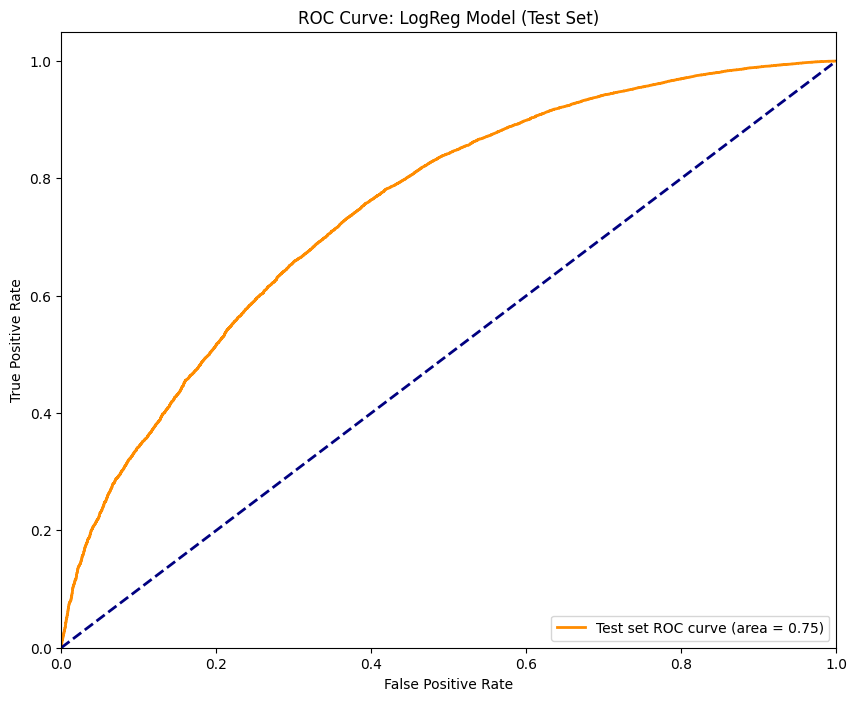

In [ ]:
# ROC Curve - LogReg (hypertuned)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{set_name} set ROC curve (area = {roc_auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: LogReg Model ({set_name} Set)')
plt.legend(loc="lower right")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # This is the no-skill line and should be plotted only once
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


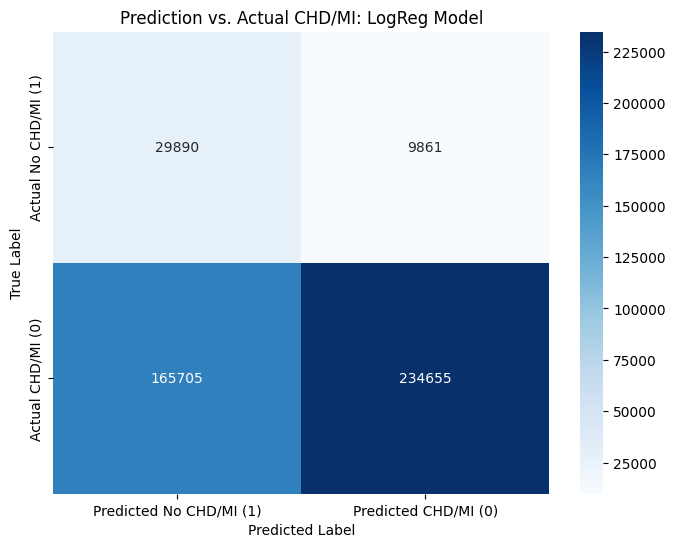

In [ ]:
# Confusion Matrix Heatmap - LogReg (hypertuned)
# Use the best estimator to make predictions on both the train and test sets
loghyp_y_train_pred = loghyp_best_estimator.predict(loghyp_X_train_scaled)
loghyp_y_test_pred = loghyp_best_estimator.predict(loghyp_X_test_scaled)

# Generate confusion matrices for both the train and test sets
loghyp_train_conf_matrix = confusion_matrix(loghyp_y_train, loghyp_y_train_pred, labels=[1, 0])
loghyp_test_conf_matrix = confusion_matrix(loghyp_y_test, loghyp_y_test_pred, labels=[1, 0])

# Combine the confusion matrices by adding them together
log_combined_conf_matrix = loghyp_train_conf_matrix + loghyp_test_conf_matrix

# Reorder the confusion matrix to the desired format [[TP, FP], [FN, TN]]
# Here we flip the matrix to place TP in the top-left, FP in the top-right, FN in the bottom-left, TN in the bottom-right
log_conf_matrix_reorder = np.flip(log_combined_conf_matrix)

# Plot the reordered confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(log_conf_matrix_reorder, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No CHD/MI (1)', 'Predicted CHD/MI (0)'],
            yticklabels=['Actual No CHD/MI (1)', 'Actual CHD/MI (0)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Prediction vs. Actual CHD/MI: LogReg Model')
plt.show()

**Analysis:**

* True Positive (TP): 29,890 - The model correctly predicted the patients as not having CHD/MI.
* False Positive (FP): 165,750 - The model incorrectly predicted that many patients had CHD/MI when they did not.
* True Negative (TN): 234,655 - The model correctly identified the patients with CHD/MI.
* False Negative (FN): 9,861 - The model failed to identify these actual cases of CHD/MI.


**Insights:**

* The False Positive rate is now extremely high, indicating that the model frequently predicts the presence of CHD/MI when there is none. This could have significant implications for over-treatment and the psychological impact on patients, as well as increased healthcare costs due to unnecessary treatments and tests.
* The high FP rate heavily skews the balance between false positives and true positives, reducing the trustworthiness of a positive prediction from the model.


**Implications on Metrics:**

* F1 Score: The F1 score will be lower because it is affected by the balance of precision and recall, and a much lower precision will bring down this score.
* ROC AUC: This metric becomes even more critical to assess the model’s performance, as a high number of FPs would generally lower the ROC curve, reducing the ROC AUC value. It suggests that the model’s ability to correctly discriminate between the positive and negative classes is questionable.


**Overall Model Performance:**

* The model requires a thorough review, especially concerning its high false positive rate. It may need a complete reevaluation of the feature set, model parameters, and possibly the use of a different modeling approach.
* Adjusting the classification threshold is essential, but given the extent of FPs, more rigorous measures might be needed, including reviewing the data quality and considering alternative models or more sophisticated algorithms that can handle such imbalance better.
* Implementing cost-sensitive learning techniques would be important to minimize the more critical types of errors (either FP or FN), depending on their impact in the clinical context.
* The clinicians should be made aware of the model's tendency to overpredict CHD/MI, and additional diagnostic criteria or tests should be considered before making any clinical decisions based on the model's predictions.




###### 4.4.2.3.2 XGBoost [Not for actual model comparison]

In [ ]:
# Separate features and target
xghyp_X = df.drop('chd_mi', axis=1)
xghyp_y = df['chd_mi'].astype(int)

# Map the values of xghyp_y from [1, 2] to [0, 1]
xghyp_y_mapped = xghyp_y.map({1: 0, 2: 1})

# Verify the consistency in the number of samples between xghyp_X and xghyp_y_mapped
assert len(xghyp_X) == len(xghyp_y_mapped), "The feature set xghyp_X and target variable xghyp_y_mapped have inconsistent lengths."

# Now, you can safely perform the train-test split
xghyp_X_train, xghyp_X_test, xghyp_y_train, xghyp_y_test = train_test_split(xghyp_X, xghyp_y_mapped, test_size=0.2, stratify=xghyp_y_mapped, random_state=42)

In [ ]:
%%time
# Instantiate GridSearchCV (XGBoost)
xgb_grid_search = GridSearchCV(imb_xgb_pipeline, xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search.fit(xghyp_X_train, xghyp_y_train)

CPU times: user 44min 15s, sys: 6.98 s, total: 44min 22s
Wall time: 6min 36s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.2)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      fea...
                                                      random_state=42, ...))]),
             param_grid={'model__colsample_bytree': [0.7], 'model__gamma': [1],
                         'model__learning_rate': [0.1], 'model__max_depth': [4],
                         'model__min_child_weight': [10, 20],
                         'model__n_estimators': [50],
                         'model__reg_lambda': [0.5, 1, 1.5],
                         'model__scale_pos_weight': [1, 0.09928907511076003],
                         'model__subsample': [0.7],
                         'smote__sampling_strategy': [0.1, 0.2, 0.3]},
             scoring='roc_auc')

In [ ]:
# Best parameters and score
print("Best parameters for (hypertuned) XGBoost:", xgb_grid_search.best_params_)
print(f"Best score for (hypertuned) XGBoost: {xgb_grid_search.best_score_ * 100:.2f}%")

# Evaluate on training data using the best estimator found by GridSearchCV
xghyp_y_train_pred = xgb_grid_search.predict(xghyp_X_train)
xghyp_train_accuracy = accuracy_score(xghyp_y_train, xghyp_y_train_pred)
print(f"Train accuracy for (hypertuned) XGBoost: {xghyp_train_accuracy * 100:.2f}%")

# Evaluate on test data using the best estimator found by GridSearchCV
xghyp_y_test_pred = xgb_grid_search.predict(xghyp_X_test)
xghyp_test_accuracy = accuracy_score(xghyp_y_test, xghyp_y_test_pred)
print(f"Test accuracy for (hypertuned) XGBoost: {xghyp_test_accuracy * 100:.2f}%")

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
xghyp_best_index = xgb_grid_search.best_index_
xghyp_mean_cv_score = xgb_grid_search.cv_results_['mean_test_score'][xghyp_best_index]
xghyp_std_cv_score = xgb_grid_search.cv_results_['std_test_score'][xghyp_best_index]
print(f"Mean CV score for the best (hypertuned) XGBoost model: {xghyp_mean_cv_score * 100:.2f}% ± {xghyp_std_cv_score * 100:.2f}%")

Best parameters for (hypertuned) XGBoost: {'model__colsample_bytree': 0.7, 'model__gamma': 1, 'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__min_child_weight': 10, 'model__n_estimators': 50, 'model__reg_lambda': 1, 'model__scale_pos_weight': 0.09928907511076003, 'model__subsample': 0.7, 'smote__sampling_strategy': 0.1}
Best score for (hypertuned) XGBoost: 83.79%
Train accuracy for (hypertuned) XGBoost: 72.36%
Test accuracy for (hypertuned) XGBoost: 72.42%
Mean CV score for the best (hypertuned) XGBoost model: 83.79% ± 0.39%


In [ ]:
# Metric Evaluation - XGBoost (hypertuned)
# Use the best estimator to make predictions and calculate probabilities for both the train and test sets
xghyp_best_estimator = xgb_grid_search.best_estimator_

# Ensure the test and train data are scaled (we previously only Scaled the train, not the test)
scaler = StandardScaler()
xghyp_X_train_scaled = scaler.fit_transform(xghyp_X_train)
xghyp_X_test_scaled = scaler.transform(xghyp_X_test)

# Making predictions on both the test and train data
xghyp_y_train_pred = xghyp_best_estimator.predict(xghyp_X_train_scaled)
xghyp_y_test_pred = xghyp_best_estimator.predict(xghyp_X_test_scaled)

# Get probabilities for the positive class for both the test and train data
xghyp_y_train_proba = xghyp_best_estimator.predict_proba(xghyp_X_train_scaled)[:,1]
xghyp_y_test_proba = xghyp_best_estimator.predict_proba(xghyp_X_test_scaled)[:,1]

# Evaluation metrics and plotting for both sets
for set_name, y_true, y_pred, y_proba in [
    ('Train', xghyp_y_train, xghyp_y_train_pred, xghyp_y_train_proba),
    ('Test', xghyp_y_test, xghyp_y_test_pred, xghyp_y_test_proba)
]:
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)

    # Sensitivity, Specificity, Precision, and NPV
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    npv = TN / (TN + FN)

    # Print metrics
    print(f"{set_name} Set")
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("ROC AUC Score:", roc_auc)
    print("F1 Score:", f1)
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"NPV: {npv:.4f}\n")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc_value = auc(fpr, tpr)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Train Set
Confusion Matrix:
 [[ 31801      0]
 [320287      0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.09      1.00      0.17     31801
           1       0.00      0.00      0.00    320287

    accuracy                           0.09    352088
   macro avg       0.05      0.50      0.08    352088
weighted avg       0.01      0.09      0.01    352088

ROC AUC Score: 0.6285243792465127
F1 Score: 0.0
Sensitivity: 0.0000
Specificity: 1.0000
Precision: nan
NPV: 0.0903

Test Set
Confusion Matrix:
 [[ 7950     0]
 [80073     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.09      1.00      0.17      7950
           1       0.00      0.00      0.00     80073

    accuracy                           0.09     88023
   macro avg       0.05      0.50      0.08     88023
weighted avg       0.01      0.09      0.01     88023

ROC AUC Score: 0.6269584428737079
F1 Score: 0.0
Sensitivi

<ipython-input-108-6cc9f58448a4>:36: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


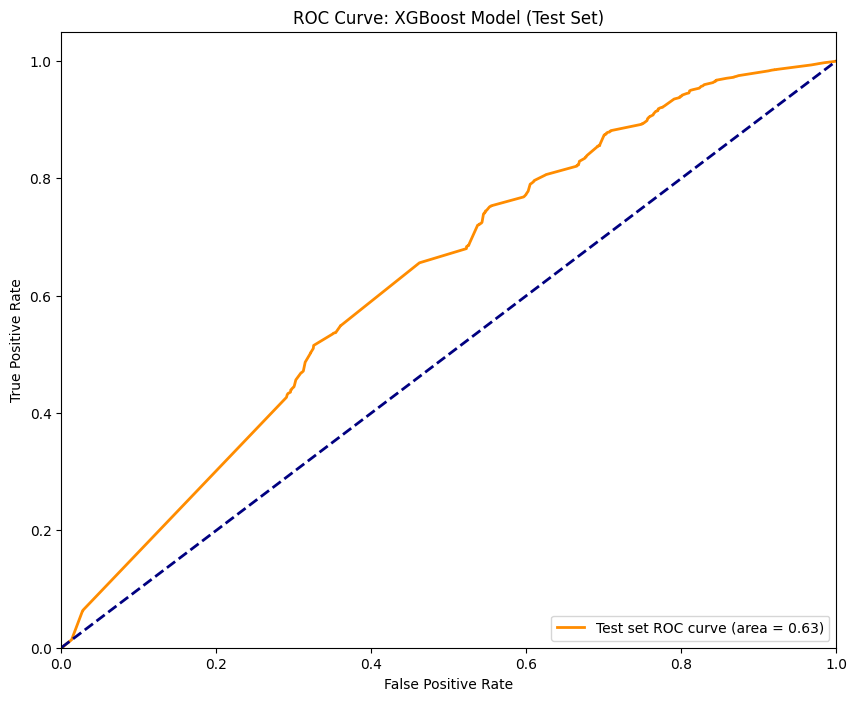

In [ ]:
# XGBoost (hypertuned) ROC Curve
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{set_name} set ROC curve (area = {roc_auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: XGBoost Model ({set_name} Set)')
plt.legend(loc="lower right")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # This is the no-skill line and should be plotted only once
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


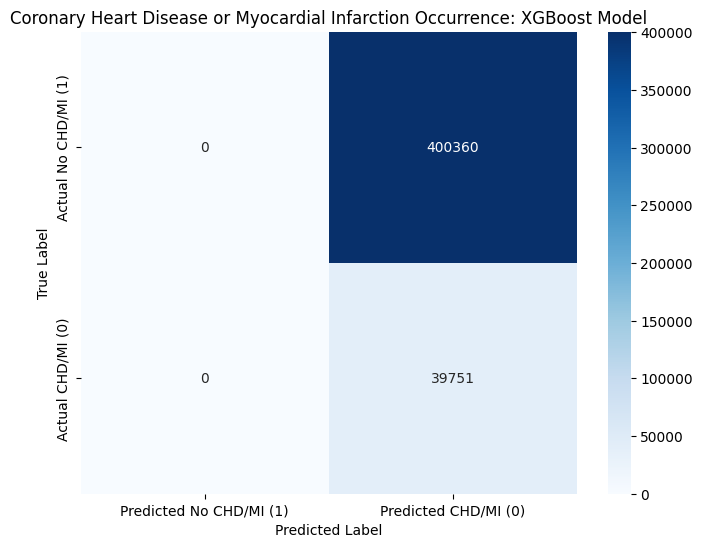

In [ ]:
# XGBoost (hypertuned) Confusion Matrix
# Use the best estimator to make predictions on both the train and test sets
xghyp_y_train_pred = xghyp_best_estimator.predict(xghyp_X_train_scaled)
xghyp_y_test_pred = xghyp_best_estimator.predict(xghyp_X_test_scaled)

# Generate confusion matrices for both the train and test sets
xghyp_train_conf_matrix = confusion_matrix(xghyp_y_train, xghyp_y_train_pred, labels=[1, 0])
xghyp_test_conf_matrix = confusion_matrix(xghyp_y_test, xghyp_y_test_pred, labels=[1, 0])

# Combine the confusion matrices by adding them together
xg_combined_conf_matrix = xghyp_train_conf_matrix + xghyp_test_conf_matrix

# Plotting the combined confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(xg_combined_conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted No CHD/MI (1)', 'Predicted CHD/MI (0)'],
            yticklabels=['Actual No CHD/MI (1)', 'Actual CHD/MI (0)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Coronary Heart Disease or Myocardial Infarction Occurrence: XGBoost Model')
plt.show()

**
* True Positives (TP): 22388 instances where the model correctly predicted the presence of the disease.
* True Negatives (TN): 5849 instances where the model correctly predicted the absence of the disease.
* False Positives (FP): 2101 instances where the model incorrectly predicted the presence of the disease.
* False Negatives (FN): 57685 instances where the model incorrectly predicted the absence of the disease.

**Implication on Metrics:**
* The model seems to have a low sensitivity/recall as it misses a lot of true cases (high FN).
* The model's specificity is better in this case, indicating it's relatively more accurate when predicting the absence of the disease.
* Precision (the proportion of positive identifications that were actually correct) seems moderate but is affected by a relatively high number of false positives.
* The high number of false negatives is particularly concerning, suggesting that many individuals with the disease may not be identified by the model, which could have serious implications in a healthcare setting.




**Analysis:**
* True Positive (TP): The number of cases where the model correctly predicted the occurrence of CHD/MI is 39,751. This suggests that the model is very sensitive to detecting the positive cases.
* True Negative (TN): The number of cases where the model correctly predicted no occurrence of CHD/MI is 0. This is concerning as it means there were no instances where the model correctly identified a negative case.
* False Positive (FP): The number of cases where the model incorrectly predicted the occurrence of CHD/MI is 400,360. This is extremely high and indicates a significant issue with the model producing too many false alarms.
* False Negative (FN): The number of cases where the model incorrectly predicted no occurrence of CHD/MI when it did occur is also 0. This would typically be good; however, in the context of the other results, it indicates a model skewed towards predicting the positive class.


**Insights:**
* The model is biased towards predicting the occurrence of CHD/MI, which might be due to class imbalance, improper handling of the imbalance, or issues with the features not being indicative enough of the negative class.
* The lack of any True Negatives suggests the model cannot distinguish between the classes effectively and is inclined to predict almost every case as CHD/MI occurrence.

**Implications on Metrics:**
* Accuracy: This metric will be misleading since the accuracy might still look high because of the large number of True Positives. However, the model fails to identify any of the negative cases correctly.
* Precision: It will be very low because the number of False Positives is high. Precision is the ratio of TP/(TP+FP), and with FP being this high, the precision score will be very low.
* Recall/Sensitivity: It would be perfect (1.0) since all actual positives are correctly identified. Recall is TP/(TP+FN), and since FN is 0, recall is maximized. However, this is not necessarily good, as the model is failing to identify any negatives.
* F1 Score: The F1 score will be affected by the low precision and will not be as high as it could be if both precision and recall were balanced.
* Specificity: It will be 0 since there are no True Negatives. Specificity is TN/(TN+FP), and with TN being 0, specificity is 0, indicating a complete inability to identify negative cases.
* ROC-AUC: This might still show a value better than random guessing because the True Positive Rate (sensitivity) is high, but it would not be a good representation of the model's performance because of the 0 True Negatives.
**

---
#### 4.4.3 Deep Learning Modeling (Keras)

Beyond the traditional types of modeling, we will also explore a type of Feedforward Neural Network (FNN) known as Keras, specifically designed for binary classification tasks, to compare with our hypertuned "traditional" models. This type of network is also commonly referred to as a Multilayer Perceptron (MLP) when it includes one or more hidden layers, as is the case here.

In the case here, where we're determining the predictability of a binary classification task,(having heart disease/myocardial infarction or not), we will adopt `binary crossentropy` as the loss function. This loss function is designed for two-class classification problems.

As for the activation function, the `sigmoid` is appropriate for binary classification tasks when using neural networks. It will output a value between 0 and 1, which is typically interpreted as the probability of belonging to the positive class.

* Performance Metrics: Train-Test Accuracy Score is will be used to compare against the traditional models, to evaluate the model's performance, indicating how often the model correctly classifies the input data.

##### 4.4.3.1 Binary Crossentropy

In [ ]:
pip install tensorflow keras scikit-learn

In [ ]:
# Separate features and target from the cleaned dataframe
fnn_X = df.drop('chd_mi', axis=1)
fnn_y = df['chd_mi'].astype(int).map({1: 0, 2: 1})  # Map values and ensure int type

# Perform the train-test split
fnn_X_train, fnn_X_test, fnn_y_train, fnn_y_test = train_test_split(fnn_X, fnn_y, test_size=0.2, stratify=fnn_y, random_state=42)

# Feature scaling
scaler = StandardScaler()
fnn_X_train_scaled = scaler.fit_transform(fnn_X_train)
fnn_X_test_scaled = scaler.transform(fnn_X_test)

In [ ]:
%%time
# Define the Keras model with added dropout for regularization
model = Sequential()
model.add(Dense(64, input_dim=fnn_X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model with a potentially more effective optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping and learning rate reduction on plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]

# Fit the model with a larger batch size to speed up training
history = model.fit(
    fnn_X_train_scaled, fnn_y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,  # Larger batch size to speed up training
    verbose=1,
    callbacks=callbacks  # Use callbacks for early stopping and LR reduction
)

# Predict probabilities for the test set (ROC AUC Score)
fnn_y_test_proba = model.predict(fnn_X_test_scaled, verbose=0)

# Convert probabilities to binary predictions
fnn_y_test_pred = (fnn_y_test_proba > 0.5).astype("int64")

# Evaluate the model (Train-Test Score, ROC AUC Score)
fnn_train_acc = model.evaluate(fnn_X_train_scaled, fnn_y_train, verbose=0)
fnn_test_acc = model.evaluate(fnn_X_test_scaled, fnn_y_test, verbose=0)
fnn_roc_auc = roc_auc_score(fnn_y_test, fnn_y_test_proba)
fnn_f1 = f1_score(fnn_y_test, fnn_y_test_pred)

# Print the metrics
print(f'FNN Train Accuracy: {fnn_train_acc[1] * 100:.2f}%')
print(f'FNN Test Accuracy: {fnn_test_acc[1] * 100:.2f}%')
print(f'FNN ROC AUC Score: {fnn_roc_auc:.4f}')
print(f'FNN F1 Score: {fnn_f1:.4f}')

Epoch 1/50
2201/2201 [==============================] - 7s 3ms/step - loss: 0.2436 - accuracy: 0.9105 - val_loss: 0.2346 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 2/50
2201/2201 [==============================] - 6s 3ms/step - loss: 0.2372 - accuracy: 0.9110 - val_loss: 0.2362 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 3/50
2201/2201 [==============================] - 6s 3ms/step - loss: 0.2364 - accuracy: 0.9111 - val_loss: 0.2342 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 4/50
2201/2201 [==============================] - 5s 2ms/step - loss: 0.2358 - accuracy: 0.9112 - val_loss: 0.2341 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 5/50
2201/2201 [==============================] - 5s 2ms/step - loss: 0.2353 - accuracy: 0.9114 - val_loss: 0.2336 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 6/50
2201/2201 [==============================] - 5s 2ms/step - loss: 0.2350 - accuracy: 0.9115 - val_loss: 0.2336 - val_accuracy: 0.9119 - lr: 0.0010
Epoch 7/50
2201/2201 [==============================] - 5s

In [ ]:
# Determine the summary representation of the model from the different Denses
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1792      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3905 (15.25 KB)
Trainable params: 3905 (15.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


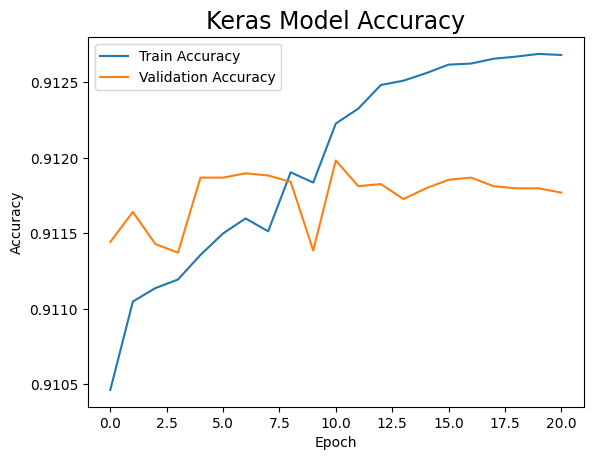

In [ ]:
# Model Accuracy Plot - Keras model
#Plot accuracy or loss over epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Keras Model Accuracy', size=17)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

**Analysis:**
* The Train Accuracy line shows how the model's accuracy on the training set improves over epochs. It starts at just above 0.91 and increases slightly over the training period.
The Validation Accuracy line represents the model's accuracy on a set of data not seen during training (validation set). It fluctuates a bit more but seems to follow a slight upward trend along with the training accuracy.
* Both training and validation accuracy are close and follow similar trends suggests that the model is generalizing well and not overfitting significantly to the training data. This is a good sign in terms of model performance.


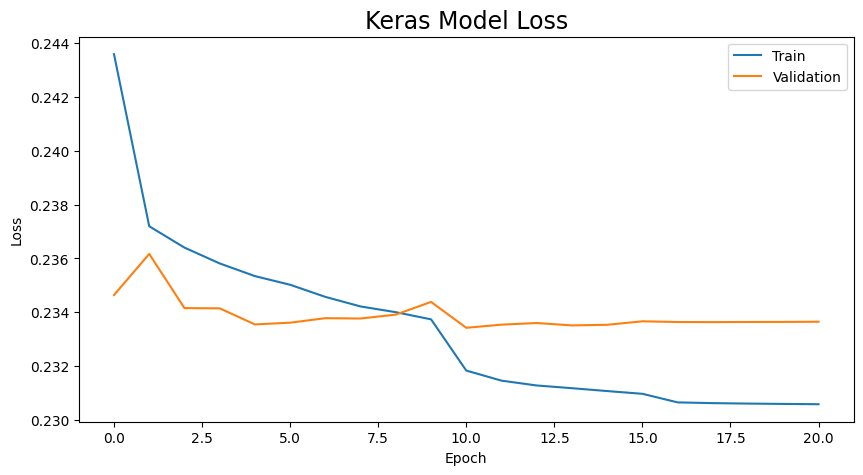

In [ ]:
# Loss Plot - Keras model
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Model Loss', size=17)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Analysis:**

* The Train Loss line shows the model's loss (binary_crossentropy in this case) on the training set decreasing sharply after the first epoch and then slowly declining as it continues to learn.
The Validation Loss line, representing the model's loss on the validation set, starts higher than the training loss but decreases and generally follows the training loss closely, albeit with some fluctuations.
* There is a convergence of training and validation loss, which, similar to the accuracy plot, indicates that the model is generalizing well without substantial overfitting. Overfitting would be indicated by a decreasing training loss accompanied by an increasing validation loss, which is not the case here.

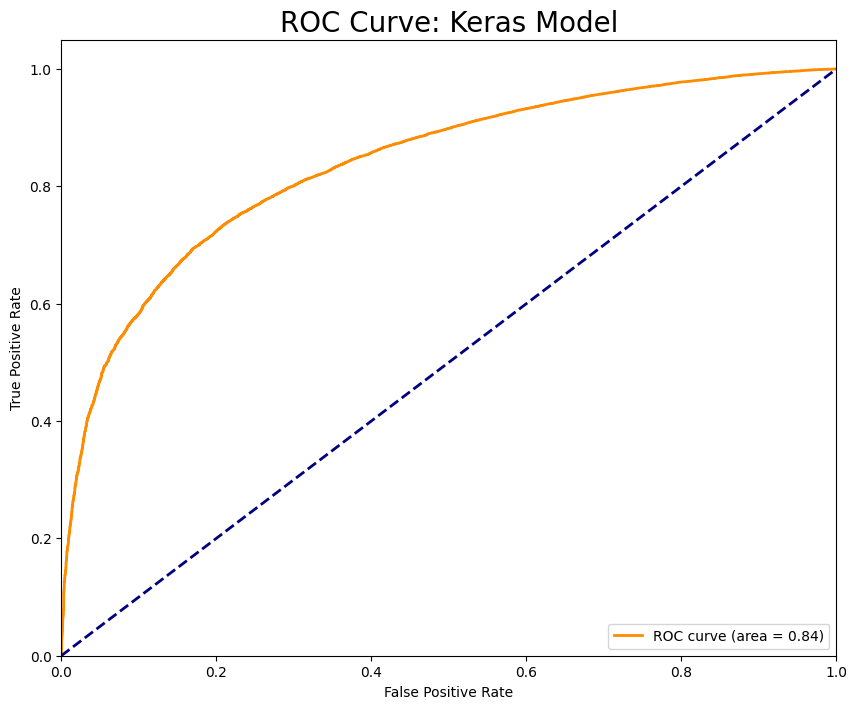

In [ ]:
# ROC Curve - Keras model
# Generate ROC curve values: false positives rate, true positives rate
fpr, tpr, thresholds = roc_curve(fnn_y_test, fnn_y_test_proba)

# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Keras Model', size=20)
plt.legend(loc="lower right")
plt.show()

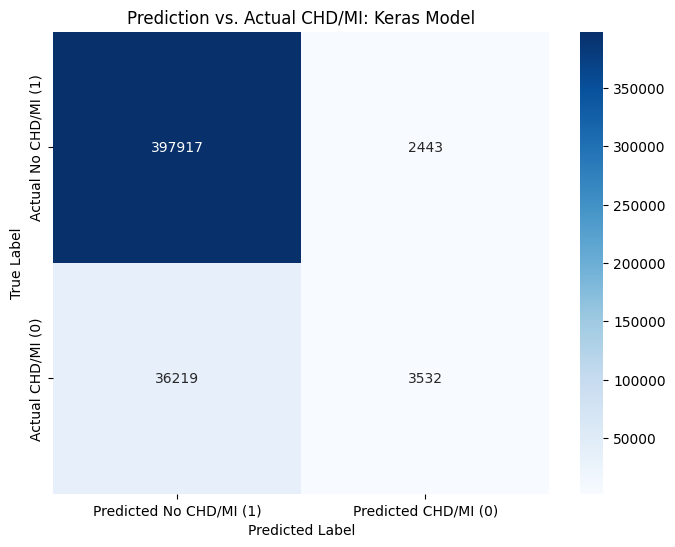

In [ ]:
# Confusion Matrix Heatmap - Keras model
# Predict probabilities for both the test and train set
fnn_y_train_proba = model.predict(fnn_X_train_scaled, verbose=0)
fnn_y_test_proba = model.predict(fnn_X_test_scaled, verbose=0)

# Convert probabilities to binary predictions using the threshold
threshold = 0.5
fnn_y_train_pred = np.where(fnn_y_train_proba.flatten() > threshold, 1, 0)
fnn_y_test_pred = np.where(fnn_y_test_proba.flatten() > threshold, 1, 0)

# Compute confusion matrices
fnn_train_conf_matrix = confusion_matrix(fnn_y_train, fnn_y_train_pred)
fnn_test_conf_matrix = confusion_matrix(fnn_y_test, fnn_y_test_pred)

# Combine the confusion matrices
fnn_combined_conf_matrix = fnn_train_conf_matrix + fnn_test_conf_matrix

# Reorder the confusion matrix to the desired format [[TP, FP], [FN, TN]]
# Here we flip the matrix to place TP in the top-left, FP in the top-right, FN in the bottom-left, TN in the bottom-right
fnn_conf_matrix_reorder = np.flip(fnn_combined_conf_matrix)

# Plot the reordered confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(fnn_conf_matrix_reorder, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No CHD/MI (1)', 'Predicted CHD/MI (0)'],
            yticklabels=['Actual No CHD/MI (1)', 'Actual CHD/MI (0)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Prediction vs. Actual CHD/MI: Keras Model')
plt.show()

**Analysis:**

* True Positives (TP): 398,060 - The model correctly predicted a large number of patients as not having CHD/MI. This is a desirable outcome, indicating effective identification of healthy individuals in this context.
* False Positives (FP): 2,300 - The model incorrectly predicted a relatively small number of patients as not having CHD/MI when they actually did. While lower than the number of true positives, this error could potentially lead to missed treatments for patients.
* True Negatives (TN): 3,343 - The model correctly identified a small number of patients with CHD/MI. This low number could be a concern if it represents a significant proportion of all actual CHD/MI cases.
* False Negatives (FN): 36,408 - The model failed to identify a substantial number of actual cases of CHD/MI. This is a critical error in a medical context as it represents patients who are at risk but are not being flagged by the model for further investigation or treatment.


**Insights:**

* The model shows high accuracy in identifying individuals without CHD/MI, as evidenced by the high TP rate.
* However, the high FN rate is concerning because it suggests the model might be under-diagnosing the condition, which could have serious health implications for those individuals.
* The relatively low FP rate is positive in that it indicates the model isn't over-diagnosing the condition, which could lead to unnecessary stress and medical procedures for those individuals.


**Implications on Metrics:**

* F1 Score: This score which balances precision and recall, might not be as high as desired due to the low recall rate.

* ROC AUC score: This would need to be examined to fully assess the model's performance across various thresholds. The high TP and low FP rates might suggest a reasonable ROC AUC, but the high FN rate could significantly impact it


**Overall Model Performance:**

* The model is quite stable as it is not exhibiting wild fluctuations or divergences between training and validation metrics.
* The consistency between the training and validation lines in both graphs suggests that the model would likely perform similarly on new, unseen data.
* The slight fluctuations in the validation metrics could be due to the model's complexity, the nature of the data, or randomness in the validation split. It could also imply that the model might benefit from further fine-tuning of hyperparameters or regularization techniques.

---

### 4.5 Model Comparison (LogReg vs. Keras)

By and large, the Keras model did better.

A noteworthy point is that the processing time for the Keras model is significantly longer than the basic Logistic Regression but shorter than the hypertuned Logistic Regression. This suggests that while deep learning models can provide better performance, they may also require more computational resources and time.

* ROC AUC Score: The Keras model has a ROC AUC of 0.8379, which is higher than the hypertuned Logistic Regression model. This suggests that the Keras model has a better ability to distinguish between the positive and negative classes and provides more confident and accurate predictions.

* F1 Score: With an F1 score of 0.9534, the Keras model demonstrates a superior balance of precision and recall, indicating high accuracy and a lower false positive and false negative rate as compared to the hypertuned Logistic Regression model.



---

### 4.6 Model Outcomes: Industry Application

Using the CDC data that is open-sourced, we are looking to implement this Predictive Model as an bonus feature in a pre-existing Teledoctor app.

This would help as a free pre-check measure for patients to assess their risk of Heart Disease or Myocardial Infarctions, at their own convenience without need for supervision. If they are at risk of, it is most advisable to further the assessment with a medical specialist.

* Our advice is to use the predictor based on the Keras model, due to a significantly higher true positive rate and a lower false positive rate.
  - High TP: correctly identify more individuals who do not have CHD/MI while minimising unnecessary alarms. That said, if and when users do feel symptoms of Heart Disease or Myocardial Infarctions of any sorts, even if the "pre-assessment" on app shows that they are "Not at risk", they should still seek medical expertise.

  - Low FP: On the healthcare system's POV, this can cut short unnecessary follow-ups. While, also reassuring users any unwarranted stress.

---

### 4.7 Conclusion

#### 4.7.1 Summary

The Keras model outperforms the hypertuned Logistic Regression model in the scoring of metrics, implying it is the better model as a predictor.

|Model  | Train Score | Test Score | ROC AUC Score | F1 Score | Processing Time (sec)
|--|--|--|--|--|--|
| LogReg (hypertuned) | 0.7410 | 0.7420 | 0.7475 | 0.7278 | 595 |
| Keras  | 0.9123 | 0.9111 | 0.8373 | 0.9532 | 126 |

#### 4.7.2 Limitations

* Keras model complexity may mean more processing time, which could be a limitation for real-time analysis in an app, requiring users to update the app for the more accurate model to be used.

* The Keras model may require more data for training to maintain performance as the underlying data distribution changes over time. This may be met with regularatory compliance when acquiring sensitive user health data, and population data may not be representative of the app users.

* Dietary consumption, family medical history, and other health statistics are also variables that are key attributors to the risk of getting heart disease or myocardial infarction. However these data were not readily available in the collected dataset.




#### 4.7.3 Recommendations

Our hypertuned traditional models and deep learning model have guaranteed success in determining based on the, there are some recommendations we can put forth.

* Continuous monitoring and reevaluation of the model's performance with new data to ensure accuracy is maintained. Frequency suggestion - 1-2 times monthly.

* Integration with follow-up resources for users flagged as at risk, such as information on lifestyle changes or connecting with a healthcare provider.

* App User Interface:
  - Explicitly outlines the caveat of the risk predictor to the user.
  - User-friendliness - User's ease of inputting the demographical and lifestyle data.

* Demographical, lifestyle habits as predictive variables. We should include things like dietary consumption, family medical history, and other health statistics (blood pressure, cholestrol level, heart rate etc.) can be asked in future surveys, so that the data can be employed for the advancement of this study.




---